In [ ]:
pip install -r requirements.txt

In [1]:
import os
import io
import pandas as pd

import numpy as np
from google.cloud import storage
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import faiss

import openai
from dotenv import load_dotenv
load_dotenv()

openai.api_key = os.environ["OPENAI_API_KEY"]
print(type(openai.api_key))

<class 'str'>


In [2]:
bucket_name = "srobb-datathon"
local_base_path = "./padchest_sample" 
gcs_base_path = "padchest"
metadata_gcs_path = f"gs://{bucket_name}/{gcs_base_path}/metadata/chest_x_ray_images_labels_sample.csv"

# init client
client = storage.Client()
bucket = client.bucket(bucket_name)

In [3]:
# load CSV directly from GCS
df = pd.read_csv(metadata_gcs_path)
df["Report"].head()

0                          Study within normal limits.
1       Aortic elongation. Radiological signs of COPD.
2    No significant radiological findings. No chang...
3            Blunting of the right costophrenic angle.
4    Radiological improvement with resolution of bi...
Name: Report, dtype: object

In [4]:
df[['ImageID', 'Labels', 'Report']].sample(3)

,ImageID,Labels,Report
13,216840111366964013200840352202011315131143616_...,"['air trapping', 'costophrenic angle blunting']",Signs of air trapping. Blunting of the left co...
19,101103270798497222826083823719046670601_jw1fu2...,"['alveolar pattern', 'cardiomegaly', 'vascular...",Cardiomegaly. Blunting of both costophrenic an...
1,216840111366964012373310883942009181081546904_...,"['aortic elongation', 'COPD signs']",Aortic elongation. Radiological signs of COPD.


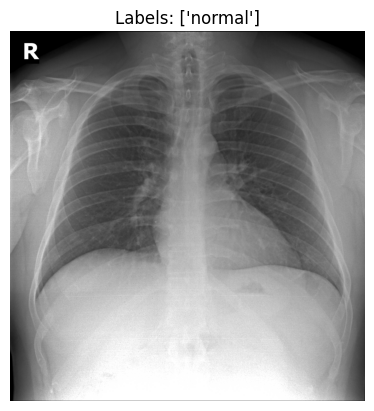

Report:
Study within normal limits.


In [5]:
# choose a sample row
sample = df.iloc[0]
image_id = sample["ImageID"]
report = sample["Report"]
labels = sample.get("Labels", "Unknown")  # fallback in case column is named differently

# pull image from GCS
image_path = f"padchest/images/{image_id}"
blob = bucket.blob(image_path)
image_data = blob.download_as_bytes()

# show image + report
img = Image.open(io.BytesIO(image_data))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Labels: {labels}")
plt.show()

print("Report:")
print(report)


In [6]:
# grab a report from your dataset
report_text = df["Report"].iloc[1]
print(report_text)

Aortic elongation. Radiological signs of COPD.


In [7]:
# grab two reports from your dataset
report_texts = [df["Report"].iloc[0], df["Report"].iloc[1]]
print(report_texts)

['Study within normal limits.', 'Aortic elongation. Radiological signs of COPD.']


In [8]:
prompt = f"""
You're a clinical assistant reviewing radiology reports.

Below are two radiology reports. For each one, extract key clinical findings.

Return ONLY a valid Python dictionary, using this format:
{{1: [...], 2: [...]}}

Do not include any explanation, markdown, or extra text—only the dictionary.

Reports:
1.
\"\"\"{report_texts[0]}\"\"\"

2.
\"\"\"{report_texts[1]}\"\"\"
"""

In [9]:
client = openai.OpenAI()

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2,
)

clinical_findings = eval(response.choices[0].message.content)
print(clinical_findings)

{1: ['Study within normal limits.'], 2: ['Aortic elongation', 'Radiological signs of COPD']}


## What Is an Image Memory?

An `ImageMemory` is a structured, semantically meaningful representation of a medical imaging event. It acts like a *memory cell* for an agent, containing everything needed to understand, compare, and reason about a specific case.

Think of it as the AI’s version of a clinical chart entry—but embedded with intelligence.

---

### Core Components of an Image Memory

| Field         | Purpose                                                                 |
|---------------|-------------------------------------------------------------------------|
| `image_id`    | Unique identifier for the image                                         |
| `gcs_path`    | Cloud location to access the raw image                                  |
| `report`      | Free-text radiology report associated with the image                   |
| `label`       | Diagnostic label(s), structured (e.g., “pneumonia”, “cardiomegaly”)     |
| `findings`    | Extracted short phrases summarizing key observations                   |
| `embedding`   | 1536-d vector capturing semantic meaning of findings/report             |

---

### Conceptually:
An `ImageMemory` is to a radiologist’s brain what a chunked memory is to an agent:
> "I’ve seen something like this before—it had similar findings, here’s what it looked like, and here’s what I thought at the time."

It bridges:
- Visual data (X-ray)
- Text data (report, findings)
- Structured logic (labels, embeddings)
- Agentic cognition (memory, reflection, recall)

---

### Why This Is Powerful:
It gives your agent the ability to think longitudinally, not just answer in the moment.

Imagine future steps:
- Retrieve similar past ImageMemories based on semantic similarity
- Reflect: “What makes this case different from those?”
- Flag: “Findings are rare—are we missing something?”
- Summarize: “Out of 40 similar cases, 30 were diagnosed with X”

---

Would you like to refine the data structure further or keep it lean and flexible for now?

Once we're aligned on that, we can decide how we want to store and query these ImageMemories.

In [10]:
# grab reports and images for first two rows
samples = df.iloc[:2]

# build memory objects
image_memories = []

for i, (index, row) in enumerate(samples.iterrows(), start=1):
    memory = {
        "image_id": row["ImageID"],
        "gcs_path": f"gs://srobb-datathon/padchest/images/{row['ImageID']}",
        "report": row["Report"],
        "label": row.get("Labels", "unknown"),
        "findings": clinical_findings.get(i, [])
    }
    image_memories.append(memory)

# display result
image_memories

[{'image_id': '216840111366964012819207061112010316094555679_04-017-068.png',
  'gcs_path': 'gs://srobb-datathon/padchest/images/216840111366964012819207061112010316094555679_04-017-068.png',
  'report': 'Study within normal limits.',
  'label': "['normal']",
  'findings': ['Study within normal limits.']},
 {'image_id': '216840111366964012373310883942009181081546904_00-027-172.png',
  'gcs_path': 'gs://srobb-datathon/padchest/images/216840111366964012373310883942009181081546904_00-027-172.png',
  'report': 'Aortic elongation. Radiological signs of COPD.',
  'label': "['aortic elongation', 'COPD signs']",
  'findings': ['Aortic elongation', 'Radiological signs of COPD']}]

In [ ]:
# Initialize FAISS
dimension = 1536
index = faiss.IndexFlatL2(dimension)
memory_map = {}

# loop over all memory objects
for idx, memory in enumerate(image_memories):
    # build embedding input
    findings_text = "; ".join(memory["findings"])
    
    # get embedding
    embedding_response = client.embeddings.create(
        model="text-embedding-3-small",
        input=findings_text
    )
    embedding = embedding_response.data[0].embedding
    memory["embedding"] = embedding

    # add to FAISS
    vec = np.array([embedding], dtype="float32")
    index.add(vec)

    # map index position to memory
    memory_map[idx] = memory

print(f"Embedded and indexed {len(image_memories)} ImageMemories.")


Embedded and indexed 2 ImageMemories.


In [ ]:
# pick one memory to simulate as the query (can be new or existing)
query_memory = image_memories[1]  # you could try 0, 1, or a new one later
query_vec = np.array([query_memory["embedding"]], dtype="float32")

# search for the top 1 most similar stored memory
D, I = index.search(query_vec, k=1)

# unpack results
matched_index = I[0][0]
matched_distance = D[0][0]
matched_memory = memory_map[matched_index]

# display
print("Search our memory for a match:")
print(f"- Image ID: {matched_memory['image_id']}")
print(f"- Distance Score: {matched_distance:.4f}")
print(f"- Findings: {matched_memory['findings']}")
print(f"- Report: {matched_memory['report']}")


Search our memory for a match:
- Image ID: 216840111366964012819207061112010316094555679_04-017-068.png
- Distance Score: 0.0000
- Findings: ['Study within normal limits.']
- Report: Study within normal limits.


In [25]:
# search top 2 to include the self-match
D, I = index.search(query_vec, k=2)

print("🔍 Search results:")
for rank in range(2):
    idx = I[0][rank]
    dist = D[0][rank]
    match = memory_map[idx]
    print(f"\nMatch {rank + 1}:")
    print(f"- Image ID: {match['image_id']}")
    print(f"- Distance Score: {dist:.4f}")
    print(f"- Findings: {match['findings']}")

🔍 Search results:

Match 1:
- Image ID: 216840111366964012819207061112010316094555679_04-017-068.png
- Distance Score: 0.0000
- Findings: ['Study within normal limits.']

Match 2:
- Image ID: 216840111366964012373310883942009181081546904_00-027-172.png
- Distance Score: 1.5748
- Findings: ['Aortic elongation', 'Radiological signs of COPD']


In [ ]:
print(dir(faiss))